In [17]:
import awkward as ak
import numpy as np
import os
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import pandas as pd
plt.style.use("figures.mplstyle")
import sys

sys.path.append("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/")
print(sys.path)
from src.HNLimits import hnl_tools

# Directory containing parquet files
base_dir = "Data/SIREN/Output/SINE_CMS_West/HNLs/"

# Regex to extract m4 and Um4 from filename
pattern = re.compile(r"m4_(\d+)_Um4_([0-9.]+)")

# Group files by (m4, Um4)
groups = defaultdict(list)
for fname in os.listdir(base_dir):
    if fname.endswith(".parquet"):
        match = pattern.search(fname)
        if match:
            m4 = match.group(1)
            Um4 = match.group(2).rstrip('.')
            groups[(m4, Um4)].append(os.path.join(base_dir, fname))

print(groups)


['/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python310.zip', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python3.10', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python3.10/lib-dynload', '', '/n/home09/nkamp/.local/lib/python3.10/site-packages', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/spack/var/spack/environments/lienv/.spack-env/._view/6xqcch3tgqvuwnqnpljuykkv3uhv5u4p/lib/python3.10/site-packages', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/', '/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neu

In [10]:
# Compute sum for each group
deltaT_cut = 1
dimuon_rate = {}
delayed_rate = {}
muon_rate = {}
full_HNL_sim = {}
for i,((m4, Um4), files) in enumerate(groups.items()):
    # if int(m4)>50000: continue
    # if float(Um4)>0.017: continue
    print("Processing group %d out of %d"%(i,len(groups)),end='\r')
    dimuon_total = 0.0
    delayed_total = 0.0
    muon_total = 0.0
    full_HNL_sim[(m4,Um4)] = ak.Array([])
    for f in files:
        try:
            data = ak.from_parquet(f)
            data["max_deltaT"] = np.max(
                np.array([data.muon0_panel1_timing_difference,
                          data.muon0_panel2_timing_difference,
                          data.muon0_panel3_timing_difference]).T,
                axis=1
                )
            for panel in range(1, 4):
                panel_transverse_disp = -np.ones((len(data),2))
                mask = data[f"muon0_panel{panel}_hit_mask"]==1
                panel_transverse_disp[mask] = np.array(data[f"muon0_panel{panel}_int_locations"][mask])[:,1,:2] - np.array(data[f"muon0_panel{panel}_int_locations"][mask])[:,0,:2]
                data[f"muon0_panel{panel}_transverse_disp"] = panel_transverse_disp

        except:
            print("Broke on %s"%f)
            continue
        # Make sure arrays are numpy for multiplication
        weights = np.array(data["weights"]*data["muon0_hit_mask_survival"]) # only surviving muons
        survival_prob = np.array(np.prod(data.survival_probs,axis=-1))
        weights *= survival_prob # account for HNL survival prob
        dimuon_mask = np.array(data["hit_mask_dimuon_survival"])
        delay_mask = np.array(data["max_deltaT"]>deltaT_cut)
        dimuon_total += np.sum(weights * dimuon_mask)
        delayed_total += np.sum(weights * delay_mask)
        muon_total += np.sum(weights)
        full_HNL_sim[(m4,Um4)] = ak.concatenate([full_HNL_sim[(m4,Um4)], data])
    dimuon_rate[(m4, Um4)] = dimuon_total
    delayed_rate[(m4, Um4)] = delayed_total
    muon_rate[(m4, Um4)] = muon_total

Broke on Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_-14_NC_m4_60000_Um4_0.01129.parquet
Broke on Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_14_NC_m4_2000_Um4_0.00162.parquet
Broke on Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_-14_NC_m4_70000_Um4_0.01129.parquet
Broke on Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_-14_NC_m4_70000_Um4_0.01129.parquet


In [11]:
m4_strings = np.unique([k[0] for k in dimuon_rate.keys()])
sort_idx = np.argsort(np.array(m4_strings,dtype=float))
m4_strings = m4_strings[sort_idx]
Um4_strings = np.unique([k[1] for k in dimuon_rate.keys()])
print(m4_strings)
print(Um4_strings)

['0700' '0800' '0900' '1000' '1500' '2000' '3000' '4000' '5000' '6000'
 '7000' '8000' '9000' '10000' '15000' '20000' '30000' '40000' '50000'
 '60000' '70000']
['0.00100' '0.00127' '0.00162' '0.00207' '0.00264' '0.00336' '0.00428'
 '0.00546' '0.00695' '0.00886' '0.01129' '0.01438' '0.01833' '0.02336'
 '0.02976' '0.03793' '0.04833' '0.06158' '0.07848' '0.10000']


In [ ]:
max = np.max(
    np.array([full_HNL_sim[("1500","0.00100")].muon0_panel1_transverse_disp,
              full_HNL_sim[("1500","0.00100")].muon0_panel2_transverse_disp,
              full_HNL_sim[("1500","0.00100")].muon0_panel3_transverse_disp])[:,:,0],
    axis=0
    )


(4087,)

['event_weight', 'event_gen_time', 'event_weight_time', 'event_global_time', 'num_interactions', 'vertex', 'primary_initial_position', 'in_fiducial', 'primary_type', 'target_type', 'num_secondaries', 'secondary_types', 'primary_momentum', 'secondary_momenta', 'parent_idx', 'num_daughters', 'int_probs', 'PDG', 'bjorken_x', 'bjorken_y', 'energy', 'hPDG', 'thx', 'thy', 'wgt', 'weights', 'muon0_panel1_int_locations', 'muon0_panel1_int_distances', 'muon0_panel1_int_coldepths', 'muon0_panel1_hit_mask', 'muon0_panel2_int_locations', 'muon0_panel2_int_distances', 'muon0_panel2_int_coldepths', 'muon0_panel2_hit_mask', 'muon0_panel3_int_locations', 'muon0_panel3_int_distances', 'muon0_panel3_int_coldepths', 'muon0_panel3_hit_mask', 'muon0_hit_mask', 'muon0_max_col_depth', 'muon0_panel1_survival', 'muon0_panel1_hit_mask_survival', 'muon0_panel2_survival', 'muon0_panel2_hit_mask_survival', 'muon0_panel3_survival', 'muon0_panel3_hit_mask_survival', 'muon0_hit_mask_survival', 'muon1_panel1_int_locat

(array([[46., 17.,  0., ...,  0.,  0.,  0.],
        [39., 59.,  7., ...,  0.,  0.,  0.],
        [48.,  6., 71., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([1.63511070e-20, 7.02464379e-20, 1.24141769e-19, 1.78037100e-19,
        2.31932430e-19, 2.85827761e-19, 3.39723092e-19, 3.93618423e-19,
        4.47513754e-19, 5.01409085e-19, 5.55304416e-19, 6.09199746e-19,
        6.63095077e-19, 7.16990408e-19, 7.70885739e-19, 8.24781070e-19,
        8.78676401e-19, 9.32571732e-19, 9.86467062e-19, 1.04036239e-18,
        1.09425772e-18, 1.14815306e-18, 1.20204839e-18, 1.25594372e-18,
        1.30983905e-18, 1.36373438e-18, 1.41762971e-18, 1.47152504e-18,
        1.52542037e-18, 1.57931570e-18, 1.63321103e-18, 1.68710636e-18,
        1.74100169e-18, 1.79489703e-18, 1.84879236e-18, 1.90268769e-18,
        1.95658302e-18, 2.01047835e-18, 2.06437368e-18, 2.11826901e

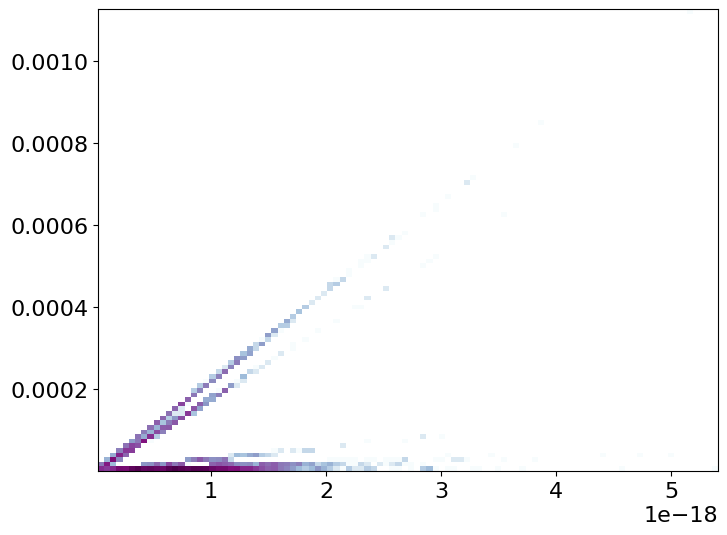

In [ ]:
example_data = full_HNL_sim[("2000","0.00100")]
print(example_data.fields)
binsXY = np.linspace(-100,100,100)
binsZ = np.linspace(0,20000,100)
plt.hist2d(np.array(example_data.event_weight),np.array(example_data.weights),bins=100,norm=LogNorm())
#plt.hist(example_data.vertex[:,1][:,2],bins=binsZ,weights=example_data.weights)
#plt.semilogy()

/tmp/ipykernel_1130191/3356600276.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # You can use 'plasma', 'inferno', 'coolwarm', etc.


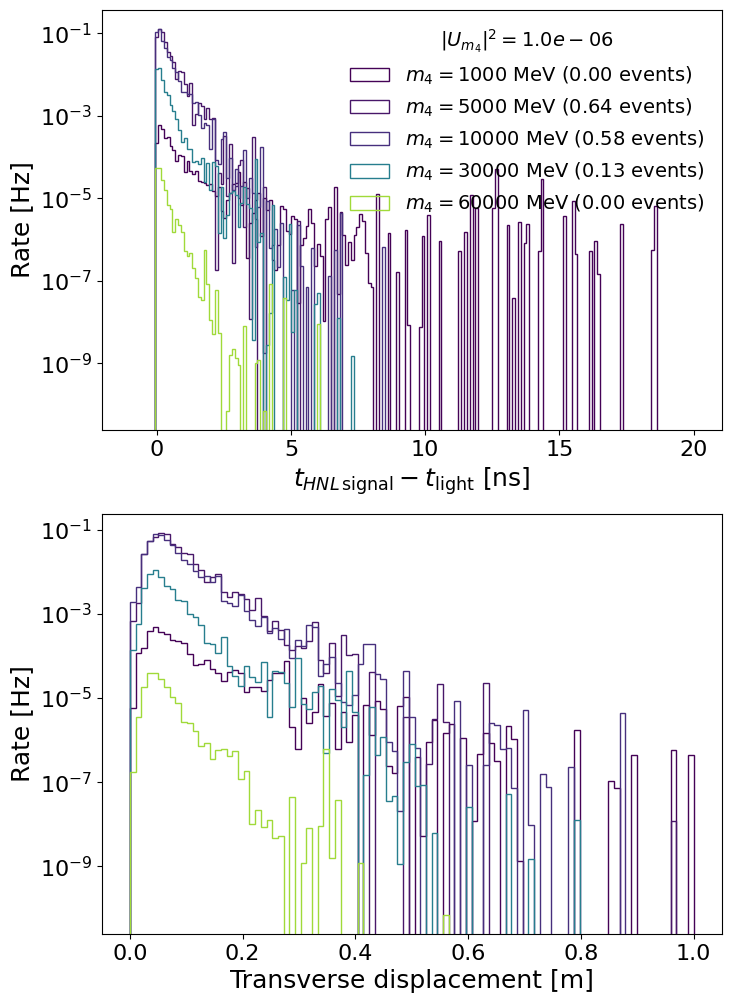

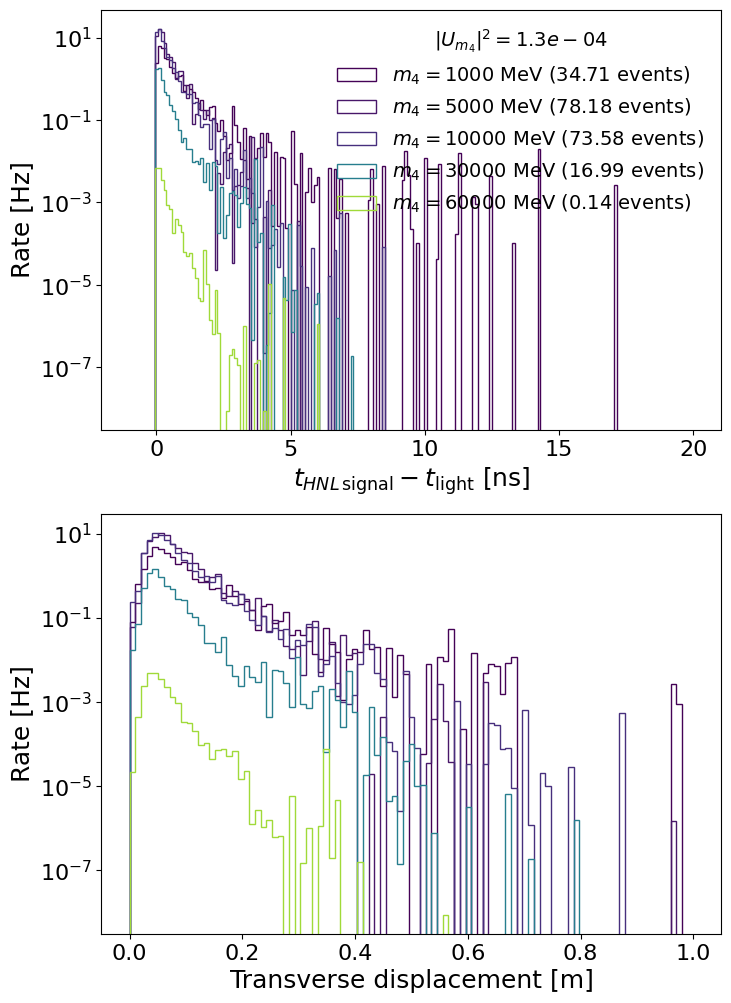

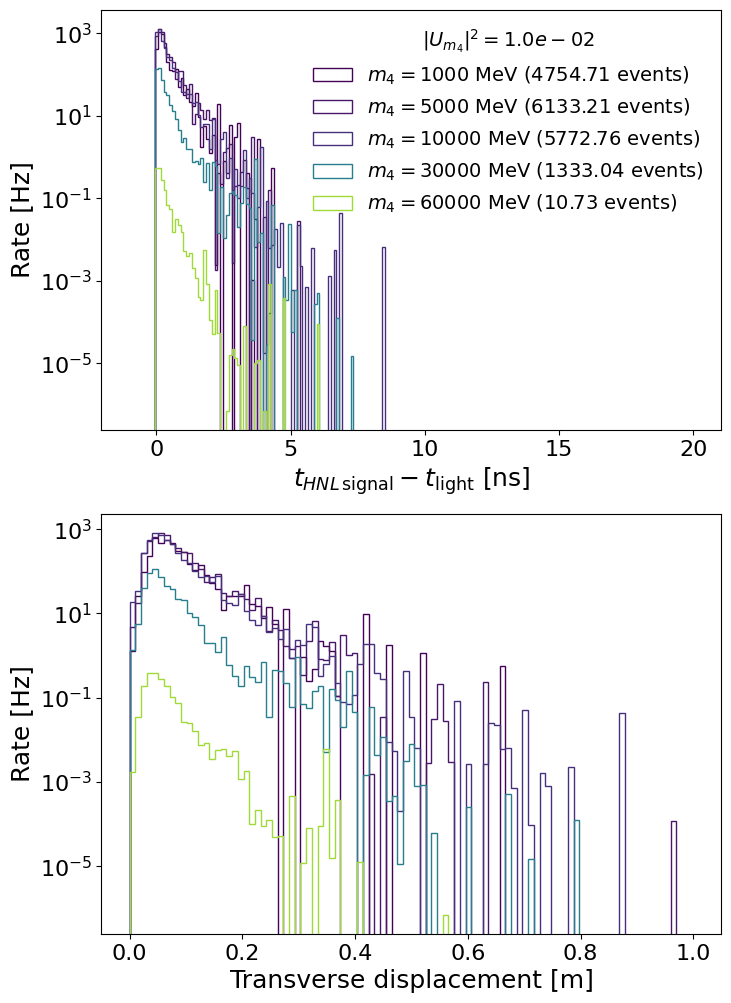

In [14]:
for Um4 in ["0.00100","0.01129","0.10000"]:
    fig,ax = plt.subplots(2,1,figsize=(8,12))
     # Create colormap
    cmap = cm.get_cmap('viridis')  # You can use 'plasma', 'inferno', 'coolwarm', etc.
    norm = mcolors.Normalize(vmin=float(m4_strings[0]), vmax=float(m4_strings[-1]))
    for m4 in ["1000","5000","10000","30000","60000"]:
        k = (m4,Um4)
        color = cmap(norm(float(m4)))
        #HNL_dist = np.linalg.norm(full_HNL_sim[k].vertex[:,1] - full_HNL_sim[k].vertex[:,0],axis=1)
        survival_prob = np.array(np.prod(full_HNL_sim[k].survival_probs,axis=-1))
        ax[0].hist(np.array(full_HNL_sim[k]["max_deltaT"]),
                     weights=np.array(full_HNL_sim[k]["weights"])*survival_prob,
                     bins=np.linspace(-1,20,200),
                     histtype="step",
                     label=r"$m_4=%s$ MeV (%1.2f events)"%(m4,sum(full_HNL_sim[k]["weights"])),
                     color=color
                     )
        maxDeltaX = np.max(
            np.array([full_HNL_sim[k].muon0_panel1_transverse_disp,
                    full_HNL_sim[k].muon0_panel2_transverse_disp,
                    full_HNL_sim[k].muon0_panel3_transverse_disp])[:,:,0],
            axis=0
            )
        maxDeltaY = np.max(
            np.array([full_HNL_sim[k].muon0_panel1_transverse_disp,
                    full_HNL_sim[k].muon0_panel2_transverse_disp,
                    full_HNL_sim[k].muon0_panel3_transverse_disp])[:,:,1],
            axis=0
            )
        ax[1].hist(np.sqrt(maxDeltaX**2 + maxDeltaY**2),
                   weights=np.array(full_HNL_sim[k]["weights"])*survival_prob,
                   bins=np.linspace(0,1,100),
                   histtype="step",
                   color=color,
                   label=r"$m_4=%s$ MeV (%1.2f events)"%(m4,sum(full_HNL_sim[k]["weights"])))
    ax[0].set_xlabel(r"$t_{HNL \,{\rm signal}} - t_{\rm light}$ [ns]")
    ax[0].set_ylabel("Rate [Hz]")
    ax[0].legend(loc="upper right",fontsize=14,title=r"$|U_{m_4}|^2=%1.1e$"%(float(Um4)**2))
    ax[0].set_yscale("log")
    ax[1].set_xlabel(r"Transverse displacement [m]")
    ax[1].set_ylabel("Rate [Hz]")
    ax[1].set_yscale("log")
    plt.show()
    plt.close(fig)

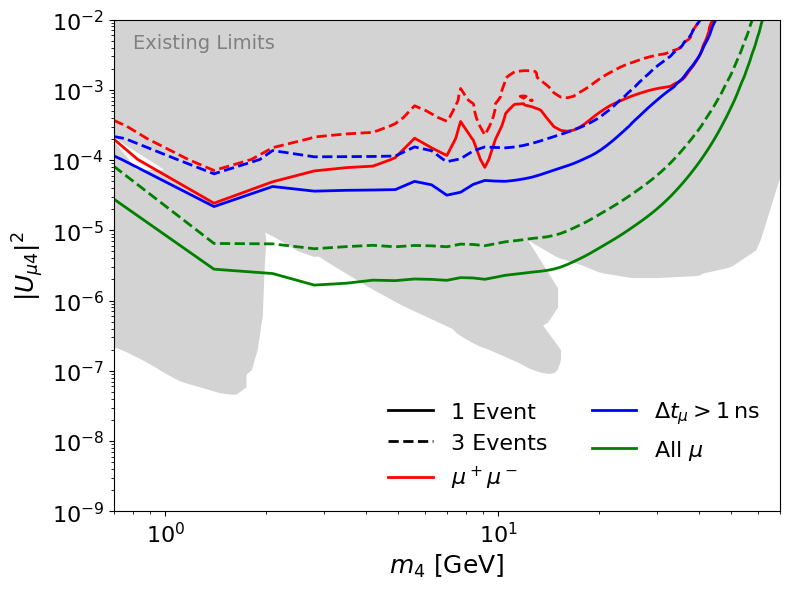

In [21]:
case_muon = hnl_tools.Limits(flavor='mu', invisible=False, nature='majorana')

import matplotlib.patches as patches
from scipy.spatial import ConvexHull

plt.figure(figsize=(8,6))

m4_range = np.logspace(np.log10(0.1),np.log10(70),200)

# first, plot existing limits
plt.text(0.8,4e-3,"Existing Limits",color="gray",fontsize=14)
for case,limit in case_muon.limits.iterrows():
    if limit.m4_top is not None and limit.plot_label!="NuTeV":
        # Create points for convex hull
        # Combine bottom and top curves
        points = np.column_stack([limit.m4,limit.ualpha4])

        # Remove any duplicate or invalid points
        points = points[~np.isnan(points).any(axis=1)]

        if len(points) > 2:
            # Compute convex hull
            hull = ConvexHull(points)

            # Create polygon from hull vertices
            hull_points = points[hull.vertices]
            polygon = patches.Polygon(hull_points, closed=True, alpha=1,
                                      facecolor='lightgray', edgecolor=None)
            plt.gca().add_patch(polygon)
    else:
        x = m4_range
        y = limit.interp_func(m4_range)
        ytop = limit.interp_func_top(m4_range)
        nan_mask = np.logical_not(np.isnan(y) | np.isnan(ytop))
        x = x[nan_mask]
        y = y[nan_mask]
        ytop = ytop[nan_mask]
        if limit.m4_top is None or np.max(np.abs(y-ytop))<1e-3:
            ytop = 1e-2*np.ones_like(ytop)
        plt.fill_between(x,y,ytop, alpha=1, facecolor='lightgray')





# next, plot our sensitivity
plt.plot([],[],color="black",label="1 Event")
plt.plot([],[],color="black",ls="--",label="3 Events")

for k,results in zip(["dimuons", "delayed_muons", "all_muons"],
                     [dimuon_rate, delayed_rate, muon_rate]):


    if k=="dimuons":
        color = "red"
        label=r"$\mu^+\mu^-$"
    elif k=="delayed_muons":
        color = "blue"
        label=r"$\Delta  t_{\mu} > 1\,{\rm ns}$"
    elif k=="all_muons":
        color = "green"
        label=r"All $\mu$"


    # Prepare data
    m4_vals = np.array([int(k[0]) for k in results.keys()])/1e3 # GeV
    Um4_sq_vals = np.array([float(k[1])**2 for k in results.keys()])
    event_sums = np.array(list(results.values()))

    # Define grid for interpolation
    m4_grid = np.linspace(m4_vals.min(), m4_vals.max(), 100)
    Um4_sq_grid = np.linspace(Um4_sq_vals.min(), Um4_sq_vals.max(), 100)
    X, Y = np.meshgrid(m4_grid, Um4_sq_grid)

    # Interpolate event_sums onto grid
    Z = griddata((np.log10(m4_vals), np.log10(Um4_sq_vals)), np.log10(event_sums), (np.log10(X), np.log10(Y)), method='cubic', fill_value=0)
    Z = 10**Z

    #pcm = plt.pcolormesh(X, Y, Z, cmap='viridis',norm=LogNorm())
    #if k=="dimuons": sc = plt.scatter(m4_vals, Um4_sq_vals, c=event_sums, cmap='viridis', s=80,norm=LogNorm(vmin=5e-1,vmax=5))
    #plt.colorbar(sc, label='Number of HNL dimuons in SINE')
    contours = plt.contour(X, Y, Z, levels=[1,3],colors=[color],linestyles=["-","--"])
    #plt.clabel(contours,fontsize=14)
    plt.plot([],[], color=color, label=label)
plt.xlabel(r'$m_4$ [GeV]')
plt.ylabel(r'$|U_{\mu 4}|^2$')
plt.loglog()
plt.ylim(1e-9,1e-2)
plt.xlim(0.7,70)
plt.tight_layout()
plt.legend(loc="lower right",ncol=2)
plt.savefig("Figures/HNL/SINE_HNL_Sensitivity.pdf",dpi=100)
plt.show()

# Cross section comparison

In [ ]:
import siren
import os

cross_section_model = "HNLDISSplines"
xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

nutype = "nu"
primary = 14
primary_type = (siren.dataclasses.Particle.ParticleType)(primary)

m4 = "0002000"
Ue4 = 0
Umu4 = 1
Utau4 = 0

HNL_DIS_xs = {}
for m4 in m4_strings:
    m4_str = f"{int(m4):07d}"
    HNL_DIS_xs[m4] = siren.interactions.HNLDISFromSpline(
        os.path.join(xsfiledir, "M_0000000MeV/dsdxdy-%s-N-nc-GRV98lo_patched_central.fits"%nutype),
        os.path.join(xsfiledir, "M_%sMeV/sigma-%s-N-nc-GRV98lo_patched_central.fits"%(m4_str,nutype)),
        float(m4)*1e-3,
        [Ue4,Umu4,Utau4],
        siren.utilities.Constants.isoscalarMass,
        1,
        [primary_type],
        [target_type],
    )

xsfiledir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/pweigel/cross_sections/20241017"
# cross_section_model = "HNLDISSplines"
# xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon
nutype = "neutrino"
nuflavor = "muon"
minQ2 = 1

DIS_xs_NC = siren.interactions.DISFromSpline(
        os.path.join(xsfiledir, "wcg24b_dsdxdy_%s_%s_%s_isoscalar.fits"%("NC",nuflavor,nutype)),
        os.path.join(xsfiledir, "wcg24b_sigma_%s_%s_%s_isoscalar.fits"%("NC",nuflavor,nutype)),
        1,siren.utilities.Constants.isoscalarMass,minQ2,
        [primary_type],
        [target_type], "cm"
    )
DIS_xs_CC = siren.interactions.DISFromSpline(
        os.path.join(xsfiledir, "wcg24b_dsdxdy_%s_%s_%s_isoscalar.fits"%("CC",nuflavor,nutype)),
        os.path.join(xsfiledir, "wcg24b_sigma_%s_%s_%s_isoscalar.fits"%("CC",nuflavor,nutype)),
        1,siren.utilities.Constants.isoscalarMass,minQ2,
        [primary_type],
        [target_type], "cm"
    )

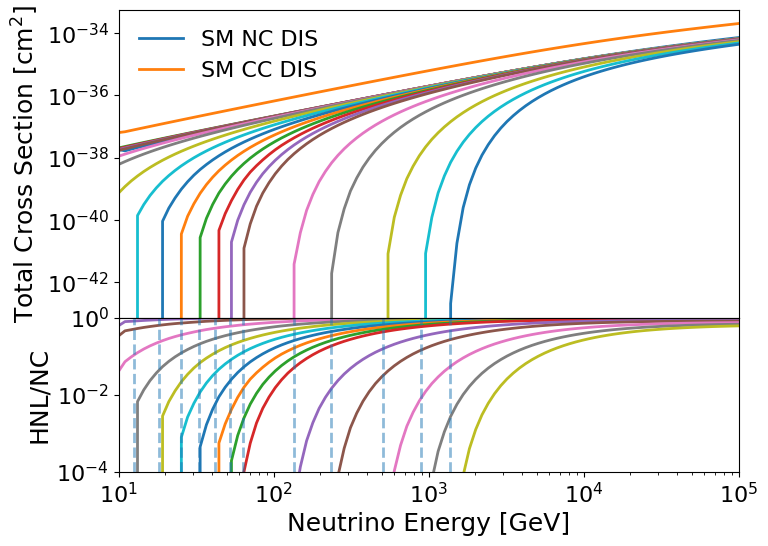

In [ ]:
import matplotlib.gridspec as gridspec

# Create a custom grid layout
fig = plt.figure()
gs = gridspec.GridSpec(2,1, height_ratios=[1, 0.5], hspace=0)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax = [ax0,ax1]

e_range = np.logspace(1,5,100) # GeV
dis_xs_vals_NC = [DIS_xs_NC.TotalCrossSection(primary_type,E) for E in e_range] # cm^2
dis_xs_vals_CC = [DIS_xs_CC.TotalCrossSection(primary_type,E) for E in e_range] # cm^2
ax[0].plot(e_range,dis_xs_vals_NC,label="SM NC DIS")
ax[0].plot(e_range,dis_xs_vals_CC,label="SM CC DIS")
for m4_str,hnl_xs in HNL_DIS_xs.items():
    threshold = hnl_xs.InteractionThreshold(siren.dataclasses.InteractionRecord())
    hnl_xs_vals = [hnl_xs.TotalCrossSection(primary_type,E) if E > threshold else 0 for E in e_range] # cm^2
    ax[0].plot(e_range,hnl_xs_vals)
    ax[1].plot(e_range,np.array(hnl_xs_vals)/np.array(dis_xs_vals_NC))
    ax[1].axvline(threshold,ls="--",alpha=0.5)
ax[0].loglog()
ax[1].loglog()
ax[1].set_xlabel("Neutrino Energy [GeV]")
ax0.tick_params(bottom=False, labelbottom=False)
ax[0].set_ylabel(r"Total Cross Section [cm$^2$]")
ax[1].set_ylabel(r"HNL/NC")
ax[0].legend()
ax[0].set_xlim(e_range[0],e_range[-1])
ax[1].set_ylim(1e-4,1)

plt.show()

# Sandbox 

In [ ]:
x = ak.from_parquet("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_-14_NC_m4_4000_Um4_0.04833.parquet")

In [ ]:
sum(x.weights*x.muon0_hit_mask_survival)

216.80551715743894

In [ ]:
x.muon0_panel3_timing_difference

<Array [0, 2.22, 0, 0.163, 0, 0, ..., 0, 0, 0, 0, 0] type='33 * float64'>

In [ ]:
x.muon0_panel1_hit_mask_survival

<Array [True, False, False, False, ..., True, True, True] type='33 * bool'>

In [ ]:
np.array(x.muon0_panel1_hit_mask_survival,dtype=int) + np.array(x.muon0_panel2_hit_mask_survival,dtype=int) + np.array(x.muon0_panel3_hit_mask_survival,dtype=int)

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1])